In [8]:
frame_count = 40

In [1]:
from tqdm import tqdm
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path

%matplotlib inline

openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%load_ext autoreload
%autoreload 2 

# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose, get_joint_pose

In [3]:
weight_name = openpose_dir.joinpath('network/weight/pose_model.pth')

model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

Bulding VGG19


In [4]:
save_dir = Path('../data/target/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

In [5]:
save_dir = Path('../data/target/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

img_path = sorted(img_dir.iterdir())[0]
img = cv2.imread(str(img_path))
img = cv2.imread('../data/target/images/aimg_0.png')
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

AttributeError: 'NoneType' object has no attribute 'shape'

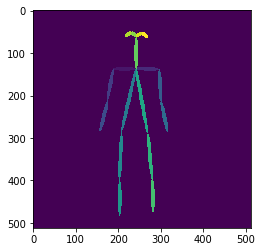

In [81]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

In [43]:
train_dir = save_dir.joinpath('train')
train_dir.mkdir(exist_ok=True)

train_img_dir = train_dir.joinpath('train_img')
train_img_dir.mkdir(exist_ok=True)
train_label_dir = train_dir.joinpath('train_label')
train_label_dir.mkdir(exist_ok=True)

#cv2.imwrite(str(train_img_dir.joinpath(f'img_{idx:04d}.png')), img)   
cv2.imwrite(str(train_img_dir.joinpath('aimg_0.png')), img)    
#cv2.imwrite(str(train_label_dir.joinpath(f'label_{idx:04d}.png')), label)
cv2.imwrite(str(train_label_dir.joinpath('alabel_0.png')), label)

True

In [52]:
target_img = cv2.imread('../data/target/train/train_label/alabel_0.png')[:,:,0]
target_img_rgb = cv2.imread('../data/target/train/train_img/aimg_0.png')
source_img = cv2.imread('../data/source/test_label/label_0117.png')[:,:,0]
source_img_rgb = cv2.imread('../data/source/test_img/img_0117.png')

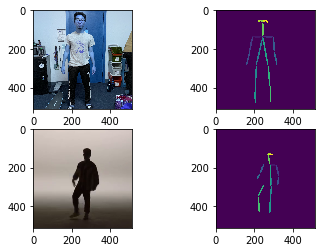

In [53]:
path = '../data/source/test_label_norm/'
save_dir = Path('../data/source/')
output = save_dir.joinpath('test_label_norm')
output.mkdir(exist_ok=True)
head_dir = save_dir.joinpath('test_head_norm')
head_dir.mkdir(exist_ok=True)
#pose_dir = Path('./data/source/pose_source.npy')
#pose_cord = np.load(str(pose_dir))

plt.subplot(222)
plt.imshow(target_img)
plt.subplot(221)
plt.imshow(target_img_rgb)
plt.subplot(224)
plt.imshow(source_img)
plt.subplot(223)
plt.imshow(source_img_rgb)
plt.savefig('norm.png')
plt.show()

In [7]:
def get_scale(label_img):
    any1 = label_img.any(axis=1)
    linspace1 = np.arange(len(any1))
    head_x, height = linspace1[list(any1)][0], len(linspace1[list(any1)])
    any0 = label_img[head_x, :] != 0
    linspace2 = np.arange(len(any0))
    head_y = int(np.mean(linspace2[list(any0)]))
    return (head_x,head_y),height

In [86]:
target_head,target_height = get_scale(target_img)
target_head_x = target_head[0]
target_head_y = target_head[1]
print(target_head)

source_head,source_height = get_scale(source_img)
source_head_x = source_head[0]
source_head_y = source_head[1]
print(source_head)

(126, 276)


((50, 229), 433)


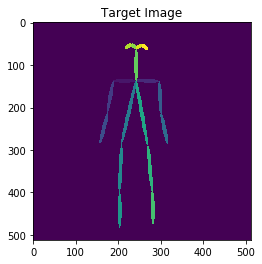

((126, 276), 311)


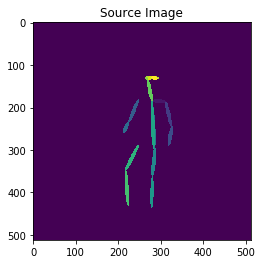

((50, 229), 433)


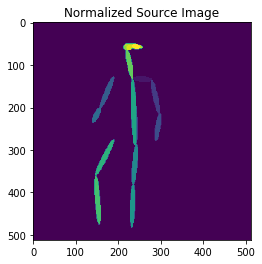

In [140]:
# rescale height of source image based on target image
source_rsize = cv2.resize(source_img, 
                          (int(source_img.shape[0] * target_height / source_height),
                          int(source_img.shape[1] * target_height / source_height))
                         )

# recalc new head coords
source_rsize_head,source_rsize_height = get_scale(source_rsize)
source_rsize_head_x = source_rsize_head[0]
source_rsize_head_y = source_rsize_head[1]

# translate source image
num_rows, num_cols = source_rsize.shape[:2]

translation_matrix = np.float32([ [1,0,-(source_rsize_head_y - target_head_y)], 
                                 [0,1,-(source_rsize_head_x - target_head_x)] ])
source_translated = cv2.warpAffine(source_rsize, translation_matrix, (num_cols, num_rows))

# print(target_img.shape[:2])
# print(source_translated.shape[:2])
# resized to 512
target_rows = target_img.shape[:2][0]
target_cols = target_img.shape[:2][0]
cropped_source_img = source_translated[:target_cols, :target_rows]

plt.imshow(target_img)
x = get_scale(target_img)
print(x)
plt.title('Target Image')
plt.show()

plt.imshow(source_img)
x = get_scale(source_img)
print(x)
plt.title('Source Image')
plt.show()

plt.imshow(cropped_source_img)
z = get_scale(cropped_source_img)
print(z)
plt.title('Normalized Source Image')
plt.show()

In [84]:
# # resize source labels based on target
# # 10 = right ankle
# # 13 = left ankle

# pos_rankle = get_joint_pose(param, heatmap, paf, 10)
# print(pos_rankle) # x, y, ., joint
# ankle joints data is not as consistent ? Thats why we chose head joints

In [130]:
# we have seen a good example of normalization
# now do normalization for all target labels 
# and save these target labels
# as new labels to be used for the pose transfer step

((114, 307), 311)


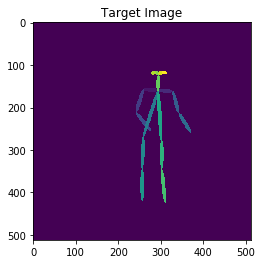

((126, 218), 302)


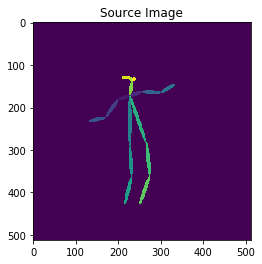

((114, 307), 312)


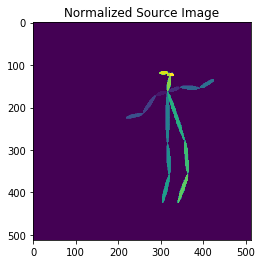

((120, 288), 302)


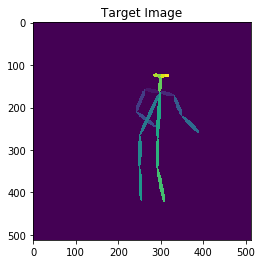

((120, 152), 318)


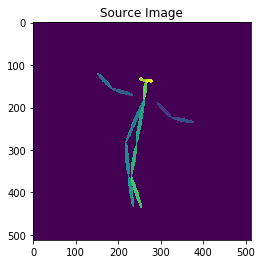

((120, 288), 302)


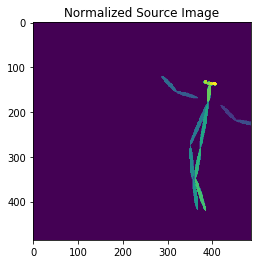

((118, 284), 316)


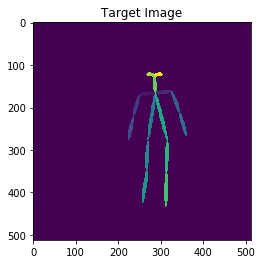

((97, 128), 336)


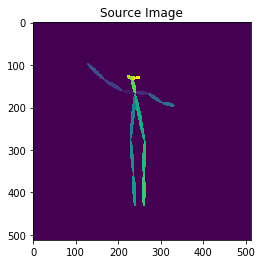

((118, 284), 316)


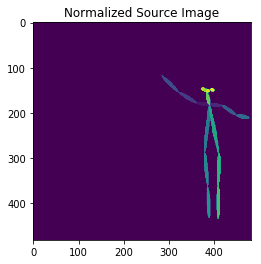

((120, 281), 315)


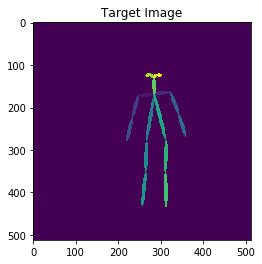

((124, 236), 316)


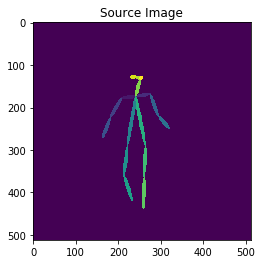

((120, 281), 316)


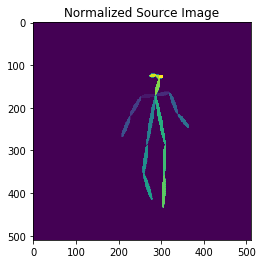

((120, 300), 303)


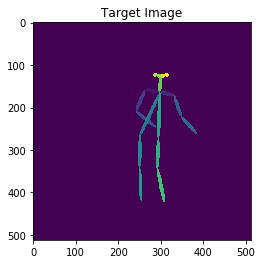

((128, 304), 308)


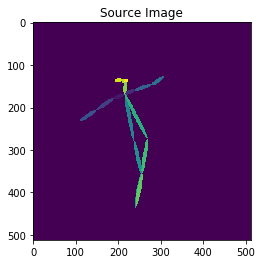

((120, 300), 304)


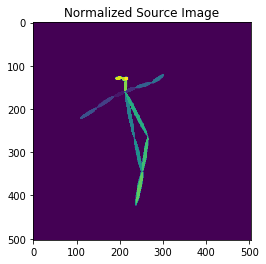

((120, 288), 303)


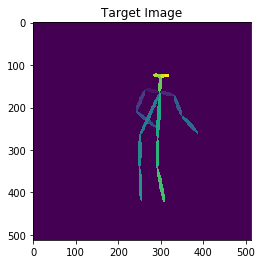

((125, 271), 315)


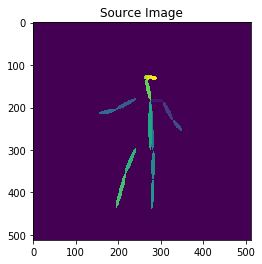

((120, 288), 303)


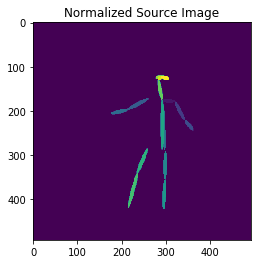

((118, 287), 313)


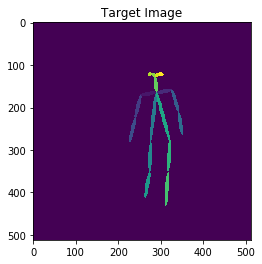

((123, 221), 311)


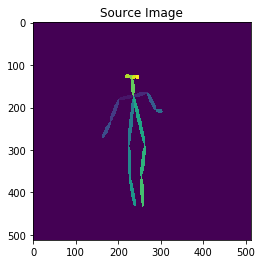

((118, 287), 314)


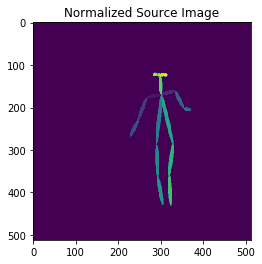

((122, 280), 313)


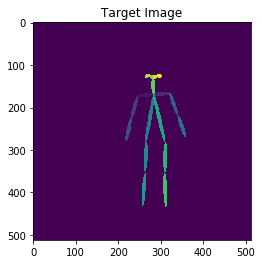

((124, 233), 237)


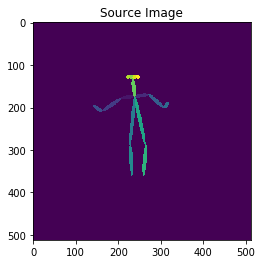

((122, 280), 314)


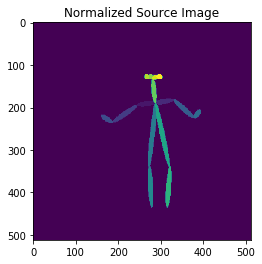

((112, 295), 314)


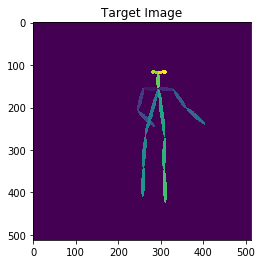

((126, 223), 306)


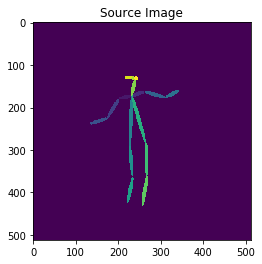

((112, 295), 314)


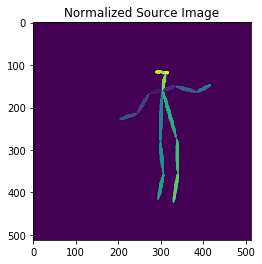

((112, 296), 312)


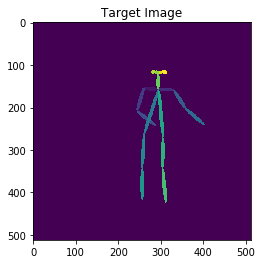

((102, 146), 337)


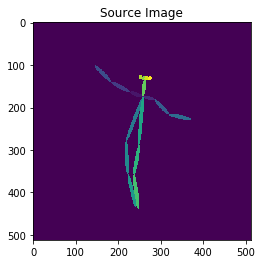

((112, 296), 313)


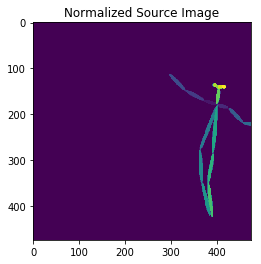

((114, 300), 315)


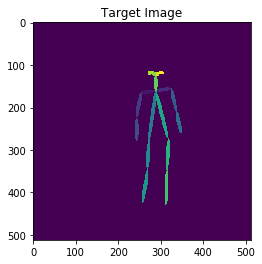

((125, 278), 313)


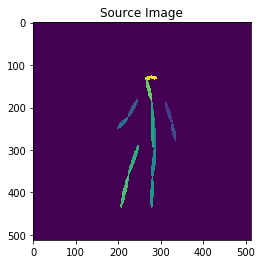

((114, 300), 316)


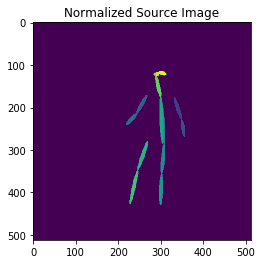

((119, 287), 305)


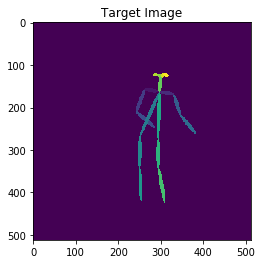

((126, 279), 316)


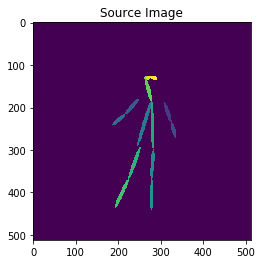

((119, 287), 306)


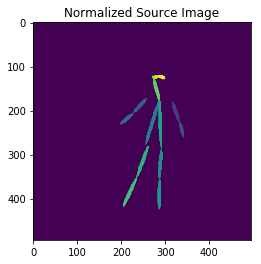

((116, 297), 309)


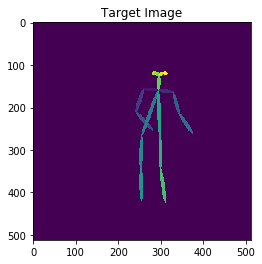

((127, 299), 310)


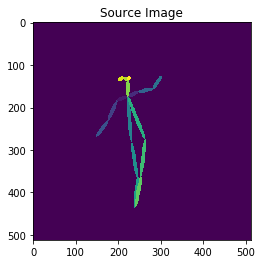

((116, 297), 310)


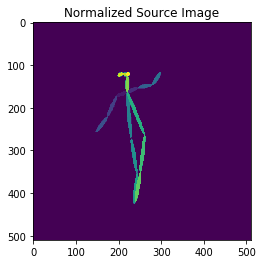

((117, 299), 314)


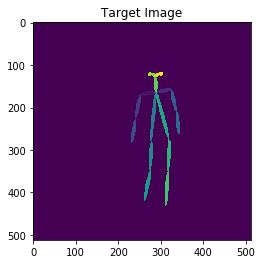

((126, 276), 311)


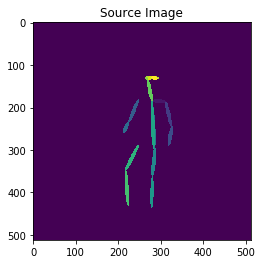

((117, 299), 314)


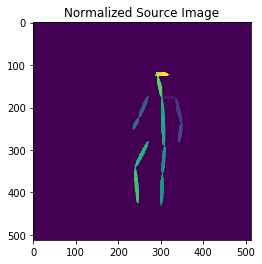

((114, 294), 311)


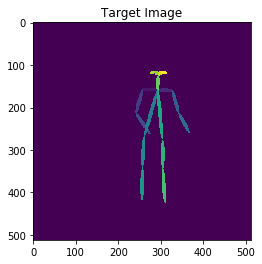

((128, 234), 309)


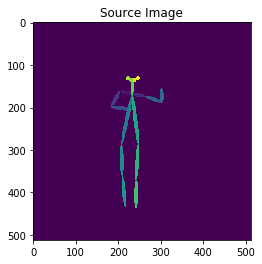

((114, 294), 312)


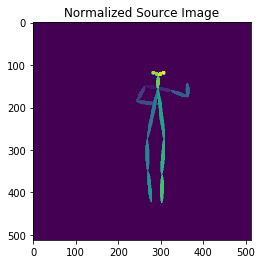

((118, 299), 303)


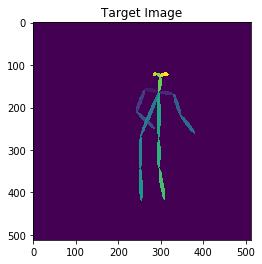

((126, 234), 313)


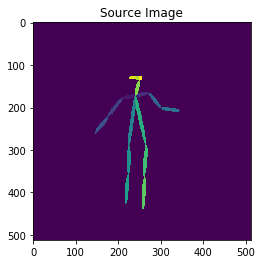

((118, 299), 304)


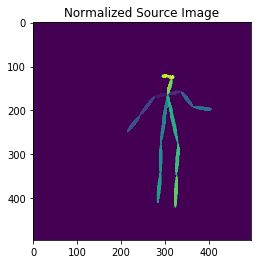

((124, 281), 311)


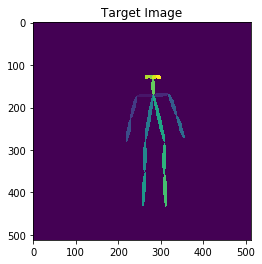

((122, 245), 313)


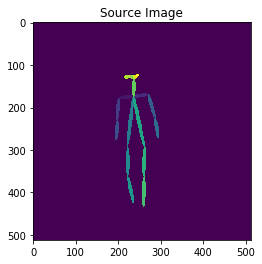

((124, 281), 311)


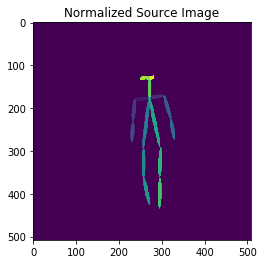

((118, 286), 313)


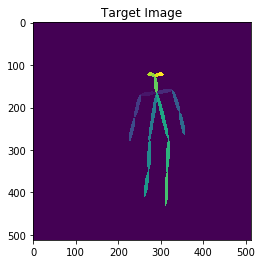

((124, 234), 310)


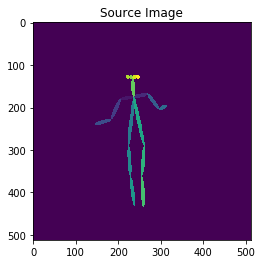

((118, 286), 314)


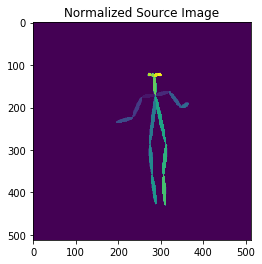

((113, 301), 315)


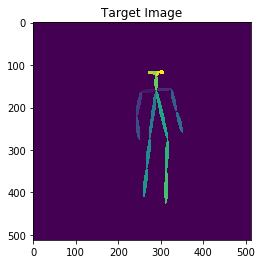

((131, 312), 306)


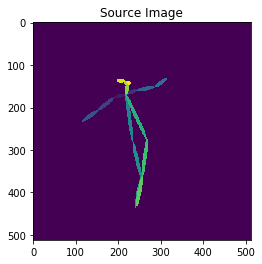

((113, 301), 316)


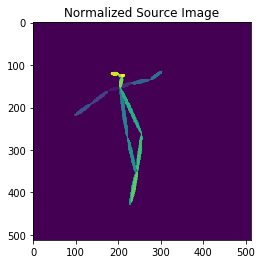

((113, 284), 311)


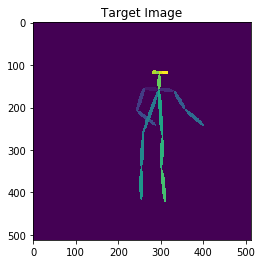

((117, 139), 308)


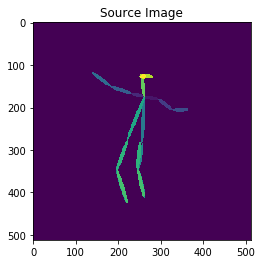

((113, 284), 312)


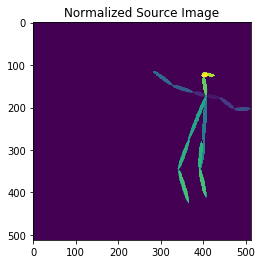

((116, 299), 309)


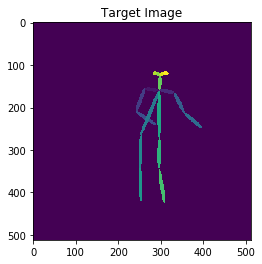

((128, 238), 308)


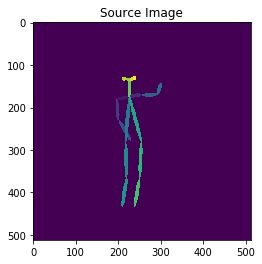

((116, 299), 309)


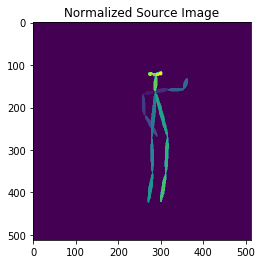

((118, 286), 314)


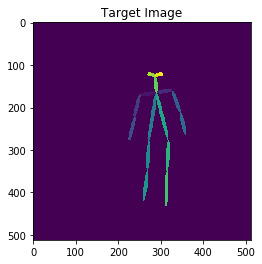

((91, 138), 348)


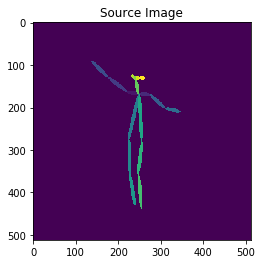

((118, 286), 314)


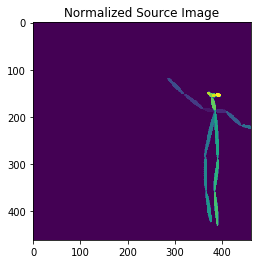

((112, 305), 315)


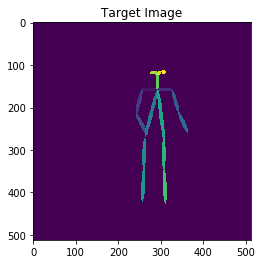

((126, 299), 309)


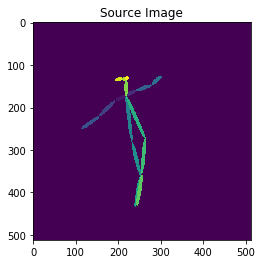

((112, 305), 315)


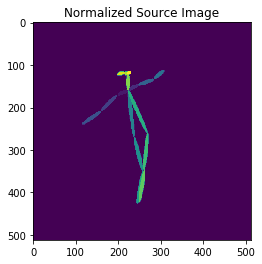

((118, 287), 313)


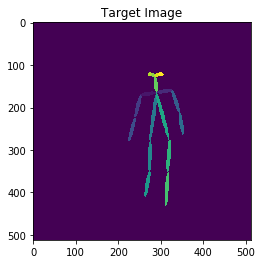

((127, 234), 308)


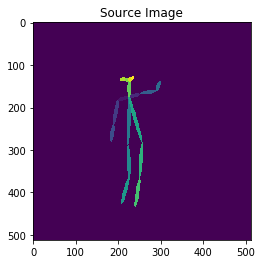

((118, 287), 313)


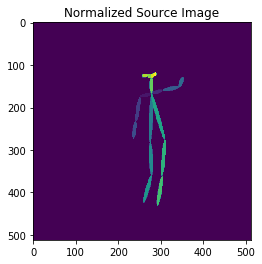

((120, 301), 303)


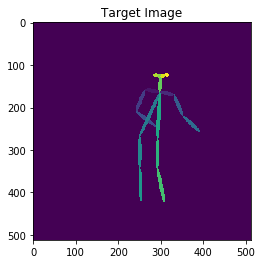

((122, 222), 315)


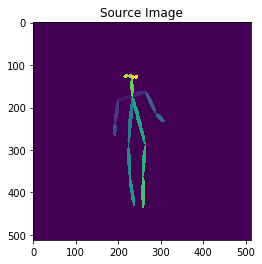

((120, 301), 303)


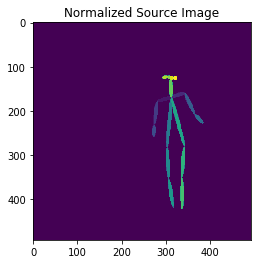

((118, 286), 315)


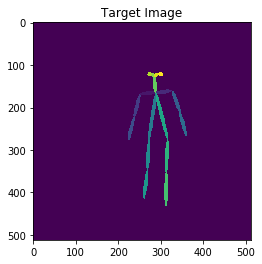

((128, 228), 307)


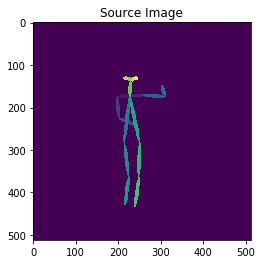

((118, 286), 316)


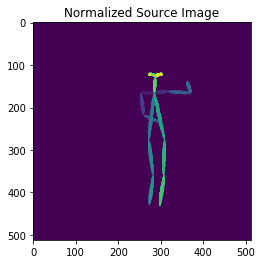

((115, 299), 315)


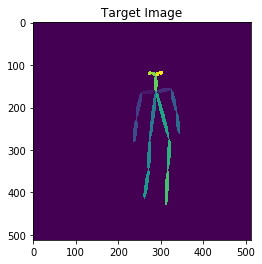

((124, 238), 309)


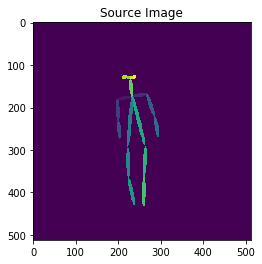

((115, 299), 315)


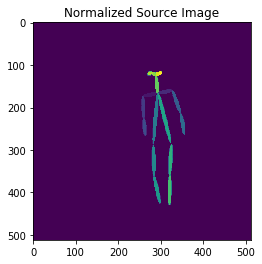

((112, 301), 316)


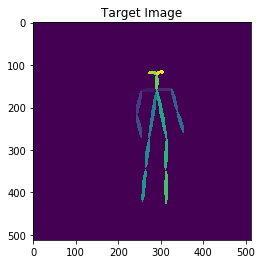

((119, 146), 310)


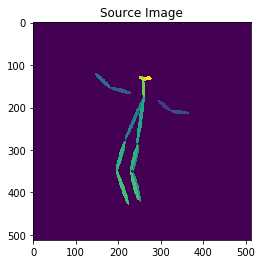

((112, 301), 316)


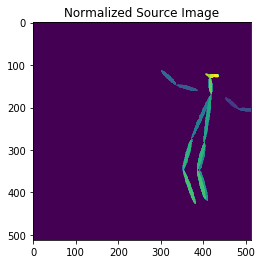

((112, 303), 316)


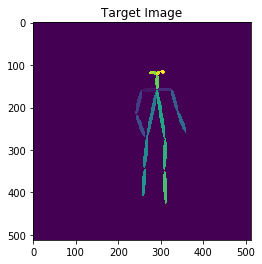

((128, 236), 308)


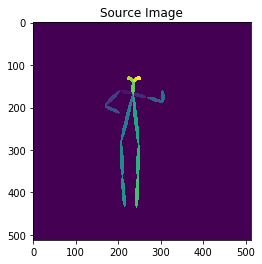

((112, 303), 317)


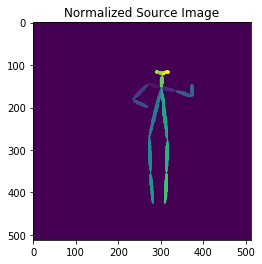

((118, 299), 314)


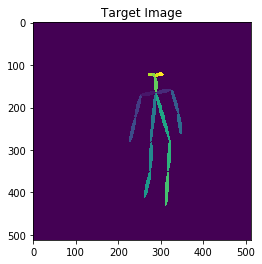

((128, 231), 308)


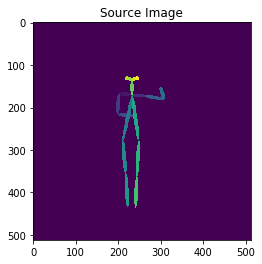

((118, 299), 314)


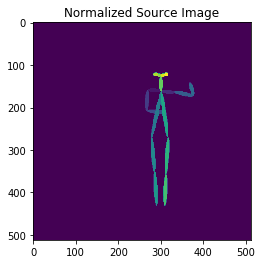

((112, 293), 314)


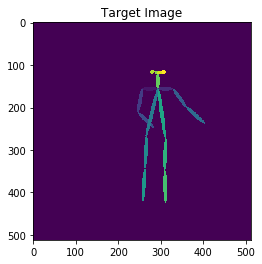

((124, 237), 316)


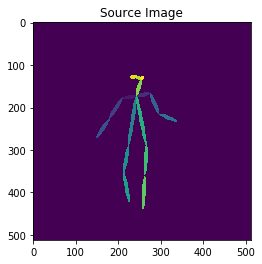

((112, 293), 314)


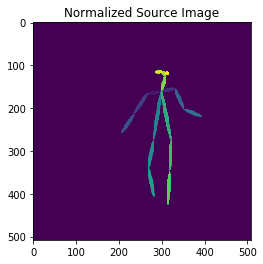

((116, 297), 308)


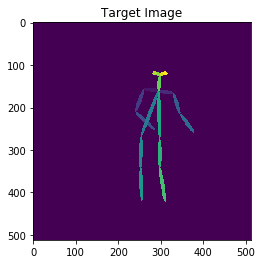

((128, 213), 299)


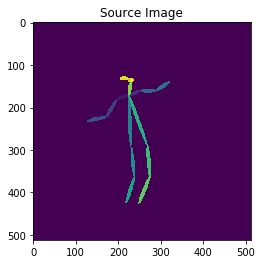

((116, 297), 309)


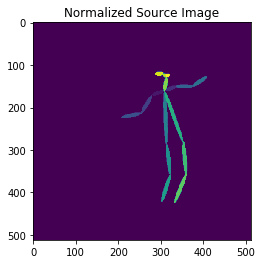

((119, 300), 303)


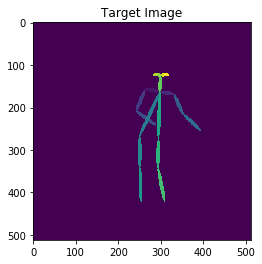

((124, 150), 311)


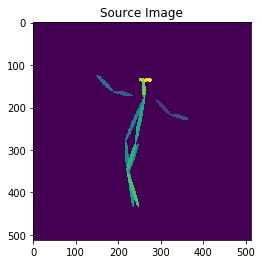

((119, 300), 303)


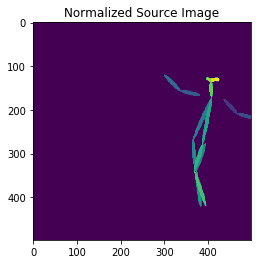

((114, 299), 311)


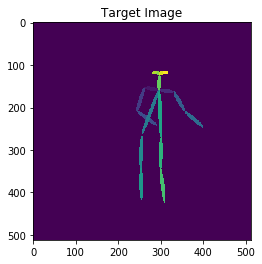

((123, 231), 314)


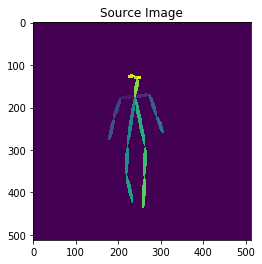

((114, 299), 312)


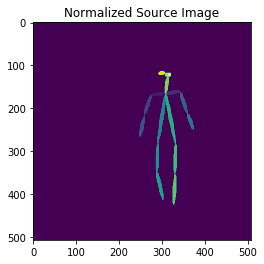

((118, 299), 314)


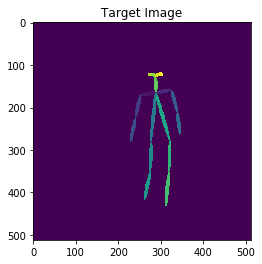

((126, 278), 311)


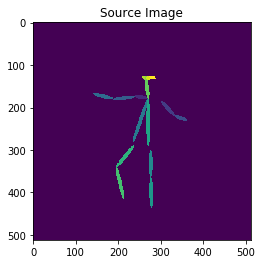

((118, 299), 314)


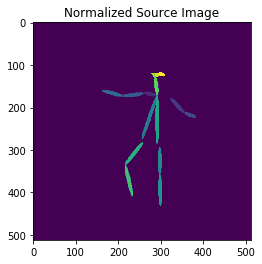

((117, 287), 307)


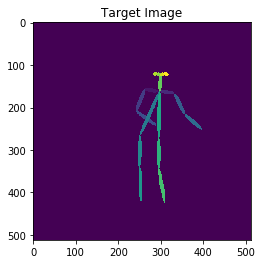

((122, 257), 304)


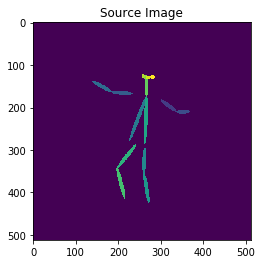

((117, 287), 308)


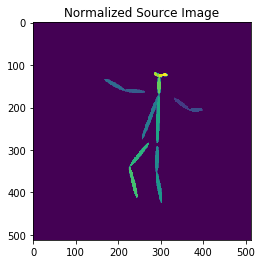

((116, 299), 315)


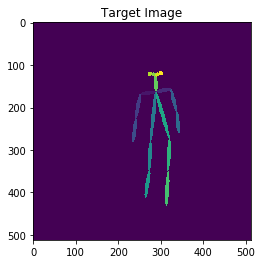

((126, 228), 313)


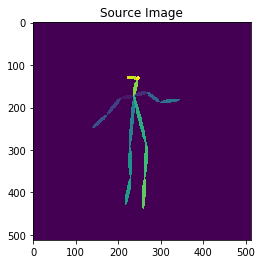

((116, 299), 316)


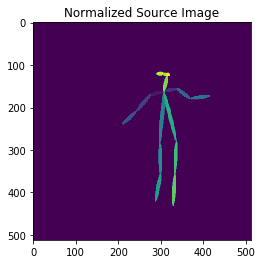

((112, 292), 314)


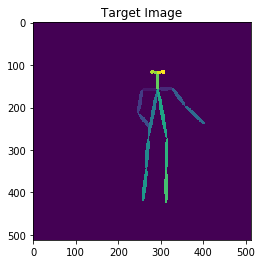

((128, 226), 307)


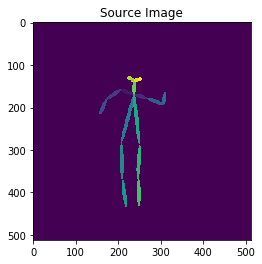

((112, 292), 315)


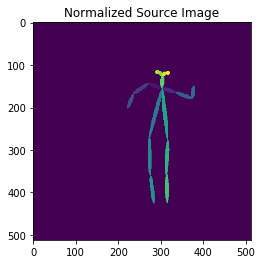

((118, 299), 314)


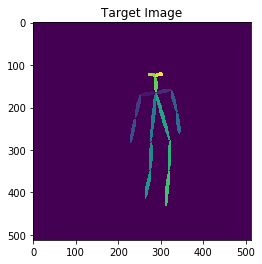

((124, 222), 314)


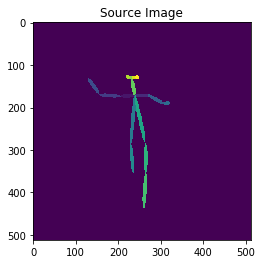

((118, 299), 314)


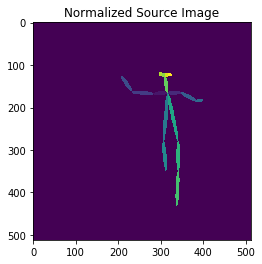

((119, 296), 313)


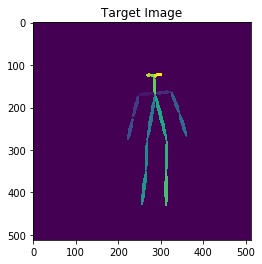

((122, 239), 317)


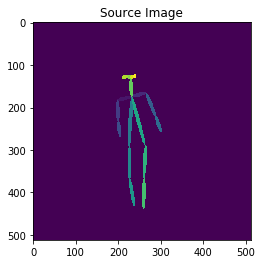

((119, 296), 313)


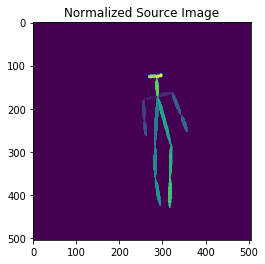

In [9]:
norm_label_dir = Path('../data/source/test_label_norm/')
norm_label_dir.mkdir(exist_ok=True)

target_label_dir = '../data/target/train/train_label'
source_label_dir = '../data/source/test_label'

for i in range(frame_count):
#     i += 1
    target_img_name = target_label_dir + '/' + os.listdir(target_label_dir)[i]
    source_img_name = source_label_dir + '/' + os.listdir(source_label_dir)[i]
    source_img_norm_name = source_label_dir + '_norm/' + os.listdir(source_label_dir)[i]
    
    target_img = cv2.imread(target_img_name)[:,:,0]
    source_img = cv2.imread(source_img_name)[:,:,0]
    
#     print(target_label)
#     print(source_label)

    target_head,target_height = get_scale(target_img)
    target_head_x = target_head[0]
    target_head_y = target_head[1]   
    source_head,source_height = get_scale(source_img)
    source_head_x = source_head[0]
    source_head_y = source_head[1]  
     
    # rescale height of source image based on target image
    source_rsize = cv2.resize(source_img, 
                              (int(source_img.shape[0] * target_height / source_height),
                              int(source_img.shape[1] * target_height / source_height))
                             )

    # recalc new head coords
    source_rsize_head,source_rsize_height = get_scale(source_rsize)
    source_rsize_head_x = source_rsize_head[0]
    source_rsize_head_y = source_rsize_head[1]

    # translate source image
    num_rows, num_cols = source_rsize.shape[:2]

    translation_matrix = np.float32([ [1,0,-(source_rsize_head_y - target_head_y)], 
                                     [0,1,-(source_rsize_head_x - target_head_x)] ])
    source_translated = cv2.warpAffine(source_rsize, translation_matrix, (num_cols, num_rows))

    # print(target_img.shape[:2])
    # print(source_translated.shape[:2])
    target_rows = target_img.shape[:2][0]
    target_cols = target_img.shape[:2][0]
    cropped_source_img = source_translated[:target_cols, :target_rows]

    plt.imshow(target_img)
    x = get_scale(target_img)
    print(x)
    plt.title('Target Image')
    plt.show()

    plt.imshow(source_img)
    x = get_scale(source_img)
    print(x)
    plt.title('Source Image')
    plt.show()

    plt.imshow(cropped_source_img)
    z = get_scale(cropped_source_img)
    print(z)
    plt.title('Normalized Source Image')
    plt.show()
    
    #save normalized labels
    cv2.imwrite(source_img_norm_name, cropped_source_img)